In [ ]:
import pymeshlab
import trimesh

scene = trimesh.Scene()
ms = pymeshlab.MeshSet()

In [ ]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

test_dataset = data_loading.get_val_dataset(
    'FAUST_a', 'test', 128, canonicalize_fmap=None, preload=False, return_evecs=True
    )[1]     

In [ ]:
data_0 = test_dataset[0]

# mesh_anis = trimesh.load_mesh('/home/s94zalek_hpc/shape_matching/data/FAUST_a/off/tr_reg_080.off')
mesh_anis = trimesh.Trimesh(vertices=data_0['second']['verts'], faces=data_0['second']['faces'])
mesh_anis.vertices += [1, 0, 0]

In [ ]:
# remesh the mesh
ms.clear()
# ms.load_new_mesh('/home/s94zalek_hpc/shape_matching/data/FAUST_a/off/tr_reg_080.off')

# v_anis, f_anis = trimesh.remesh.subdivide_to_size(mesh_anis.vertices, mesh_anis.faces, max_edge=0.01)

v_anis = mesh_anis.vertices
f_anis = mesh_anis.faces
ms.add_mesh(pymeshlab.Mesh(v_anis, f_anis))

ms.meshing_isotropic_explicit_remeshing(
    iterations=10,
    targetlen=pymeshlab.PercentageValue(1)
)

# ms.apply_coord_hc_laplacian_smoothing(
#     # stepsmoothnum=1
# )
# ms.apply_coord_laplacian_smoothing(
#     stepsmoothnum=1
# )

v_anis = ms.current_mesh().vertex_matrix()
f_anis = ms.current_mesh().face_matrix()

# mesh_anis_remeshed = trimesh.Trimesh(v_anis, f_anis)

# v_anis, f_anis = trimesh.remesh.subdivide_to_size(v_anis, f_anis, max_edge=0.02)
mesh_anis_remeshed = trimesh.Trimesh(v_anis + [1, 0, 0], f_anis)
# # apply laplacian smoothing
trimesh.smoothing.filter_laplacian(mesh_anis_remeshed, lamb=0.5, iterations=3)
# trimesh.smoothing.filter_humphrey(mesh_anis_remeshed, iterations=3)

print('before', mesh_anis.vertices.shape, mesh_anis.faces.shape)
print('after remesh', v_anis.shape, f_anis.shape)

scene.geometry.clear()

scene.add_geometry(trimesh.creation.axis())

scene.add_geometry(mesh_anis)
scene.add_geometry(mesh_anis_remeshed)
scene.show()

In [ ]:
mesh_anis_remeshed.show()

In [ ]:
import matplotlib.pyplot as plt

edges_len_anis = mesh_anis.edges_unique_length
edges_len_remeshed = mesh_anis_remeshed.edges_unique_length


fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].hist(edges_len_anis, bins=100, cumulative=False, density=True)
axs[0].set_title('Anisotropic mesh')

axs[1].hist(edges_len_remeshed, bins=100, cumulative=False, density=True)
axs[1].set_title('Remeshed mesh')

plt.show()

In [ ]:
import utils.fmap_util as fmap_util
import torch

p2p_aR_a = fmap_util.nn_query(
    torch.tensor(mesh_anis_remeshed.vertices), 
    torch.tensor(mesh_anis.vertices),
    )
p2p_aR_a

In [ ]:
p2p_a_t = data_0['second']['corr']
p2p_aR_t = p2p_aR_a[p2p_a_t]

In [ ]:
scene.geometry.clear()

plotting_utils.plot_p2p_map(
    scene,
    mesh_anis_remeshed.vertices, mesh_anis_remeshed.faces,
    mesh_anis.vertices, mesh_anis.faces,
    p2p_aR_a
    )
    
scene.show()

In [ ]:
from utils.geometry_util import get_operators

evecs_a = data_0['second']['evecs']
evecs_t = data_0['first']['evecs']

evecs_aR = get_operators(
    torch.tensor(mesh_anis_remeshed.vertices),
    torch.tensor(mesh_anis_remeshed.faces),
    k=128,
    cache_dir=None)[4].float()


In [ ]:
evecs_aR.shape

In [ ]:
p2p_aR_t.shape

In [ ]:
fmap_a_t = torch.linalg.lstsq(
    evecs_a[p2p_a_t],
    evecs_t
    ).solution.to('cpu')

fmap_aR_t = torch.linalg.lstsq(
    evecs_aR[p2p_aR_t],
    evecs_t
    ).solution.to('cpu')

In [ ]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plotting_utils.plot_Cxy(fig, axs[0], fmap_a_t, 'fmap_a_t',
                        l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], fmap_aR_t, 'fmap_aR_t',
                        l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], fmap_a_t.abs() - fmap_aR_t.abs(), 'abs diff',
                        l, h, show_grid=False, show_colorbar=False)

plt.show()

In [ ]:
import my_code.sign_canonicalization.test_sign_correction as test_sign_correction

name = 'FAUST_orig'
split = 'test'
remesh_targetlen = 3

test_dataset_curr = data_loading.get_val_dataset(
    name, split, 128, canonicalize_fmap=None, preload=False, return_evecs=True
    )[0]

test_dataset = test_sign_correction.remesh_dataset(
    test_dataset_curr, f'{name}-{split}',
    remesh_targetlen, num_evecs=128)

In [ ]:
scene.geometry.clear()

for i, idx in enumerate(range(len(test_dataset))):
    data = test_dataset[idx]

    mesh = trimesh.Trimesh(vertices=data['verts'], faces=data['faces'])
    
    mesh.vertices += [i, 0, 0]

    scene.add_geometry(mesh)
    
scene.show()

In [ ]:
n_verts = 0
n_faces = 0

for i in range(len(test_dataset)):
    n_verts += test_dataset[i]['verts'].shape[0]
    n_faces += test_dataset[i]['faces'].shape[0]
    
print(f'{name}, mean verts: {n_verts / len(test_dataset)}, mean faces: {n_faces / len(test_dataset)}')
    

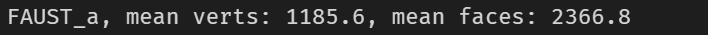

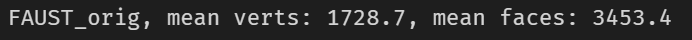

In [ ]:
import networks.diffusion_network as diffusion_network
from tqdm import tqdm
import my_code.sign_canonicalization.training as sign_training
import my_code.sign_canonicalization.remesh as remesh
import torch
import my_code.diffusion_training_sign_corr.data_loading as data_loading
import yaml
import my_code.datasets.preprocessing as preprocessing
import trimesh


def remesh_dataset(dataset, name, remesh_targetlen, smoothing_iter, num_evecs):

    new_dataset = []

    for i in tqdm(range(len(dataset)), desc=f'Remeshing the dataset {name}'):
        
        train_shape_orig = dataset[i]

        verts_orig = train_shape_orig['verts']
        faces_orig = train_shape_orig['faces']
        
        verts, faces = remesh.remesh_simplify_iso(
            verts_orig,
            faces_orig,
            n_remesh_iters=10,
            remesh_targetlen=remesh_targetlen,
            simplify_strength=1,
        )
        
        verts = verts_orig
        faces = faces_orig
        
        mesh_anis_remeshed = trimesh.Trimesh(verts, faces)
        # apply laplacian smoothing
        trimesh.smoothing.filter_laplacian(mesh_anis_remeshed, lamb=0.5, iterations=smoothing_iter)
        
        train_shape = {
            'verts': torch.tensor(mesh_anis_remeshed.vertices).float(),
            'faces': torch.tensor(mesh_anis_remeshed.faces).int(),
        }
        train_shape = preprocessing.get_spectral_ops(train_shape, num_evecs=num_evecs,
                                    cache_dir=None)
        
        new_dataset.append(train_shape)
    
    return new_dataset


def test_on_dataset(net, test_dataset, with_mass, n_epochs):

    tqdm._instances.clear()
        
    iterator = tqdm(total=len(test_dataset) * n_epochs)
    incorrect_signs_list = torch.tensor([])
    curr_iter = 0

        
    for _ in range(n_epochs):
        for curr_idx in range(len(test_dataset)):

            ##############################################
            # Select a shape
            ##############################################

            train_shape = test_dataset[curr_idx]           
            
            ##############################################
            # Set the variables
            ##############################################

            # train_shape = double_shape['second']
            verts = train_shape['verts'].unsqueeze(0).to(device)
            faces = train_shape['faces'].unsqueeze(0).to(device)    

            evecs_orig = train_shape['evecs'].unsqueeze(0)[:, :, start_dim:start_dim+feature_dim].to(device)
            
            if with_mass:
                mass_mat = torch.diag_embed(
                    train_shape['mass'].unsqueeze(0)
                    ).to(device)
            else:
                mass_mat = None

            ##############################################
            # Set the signs on shape 0
            ##############################################

            # create a random combilation of +1 and -1, length = feature_dim
            sign_gt_0 = torch.randint(0, 2, (feature_dim,)).float().to(device)
            
            sign_gt_0[sign_gt_0 == 0] = -1
            sign_gt_0 = sign_gt_0.float().unsqueeze(0)

            # print('evecs_orig', evecs_orig.shape, 'sign_gt_0', sign_gt_0.shape)

            # multiply evecs [6890 x 16] by sign_flip [16]
            evecs_flip_0 = evecs_orig * sign_gt_0
            
            
            
            # predict the sign change
            with torch.no_grad():
                sign_pred_0, supp_vec_0, _ = sign_training.predict_sign_change(
                    net, verts, faces, evecs_flip_0, 
                    mass_mat=mass_mat, input_type=net.input_type,
                    
                    mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
                    evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
                    gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
                    )
            
            ##############################################
            # Set the signs on shape 1
            ##############################################
            
            # create a random combilation of +1 and -1, length = feature_dim
            sign_gt_1 = torch.randint(0, 2, (feature_dim,)).float().to(device)
            
            sign_gt_1[sign_gt_1 == 0] = -1
            sign_gt_1 = sign_gt_1.float().unsqueeze(0)
            
            # multiply evecs [6890 x 16] by sign_flip [16]
            evecs_flip_1 = evecs_orig * sign_gt_1
            
            # predict the sign change
            with torch.no_grad():
                sign_pred_1, supp_vec_1, _ = sign_training.predict_sign_change(
                    net, verts, faces, evecs_flip_1, 
                    mass_mat=mass_mat, input_type=net.input_type,
                    
                    mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
                    evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
                    gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
                    )
            
            ##############################################
            # Calculate the loss
            ##############################################
            
            # calculate the ground truth sign difference
            sign_diff_gt = sign_gt_1 * sign_gt_0
            
            # calculate the sign difference between predicted evecs
            sign_diff_pred = sign_pred_1 * sign_pred_0
            
            sign_correct = sign_diff_pred.sign() * sign_diff_gt.sign() 
            
            
            # count the number of incorrect signs
            count_incorrect_signs = (sign_correct < 0).int().sum()
                
            # incorrect_signs_list.append(count_incorrect_signs)
            incorrect_signs_list = torch.cat([incorrect_signs_list, torch.tensor([count_incorrect_signs])])
            
            
            iterator.set_description(f'Mean incorrect signs {incorrect_signs_list.float().mean():.2f} / {feature_dim}, max {incorrect_signs_list.max()}')
            iterator.update(1)
            # if count_incorrect_signs > 7:
            #     raise ValueError('Too many incorrect signs')
        
    return incorrect_signs_list.float().mean(), incorrect_signs_list.max()



if __name__ == '__main__':
        
    exp_name = 'signNet_remeshed_4b_10_0.2_0.8' 
    
    
    exp_dir = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/sign_net/{exp_name}'
    
    with open(f'{exp_dir}/config.yaml', 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        
    remesh_targetlen = 1
    smoothing_iter = 5
    # remesh_targetlen = config['dataset']['remesh']['isotropic']['remesh_targetlen']
        
    start_dim = config['start_dim']

    feature_dim = config['feature_dim']
    evecs_per_support = config['evecs_per_support']


    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    net = diffusion_network.DiffusionNet(
        **config['net_params']
        ).to(device)

    input_type = config['net_params']['input_type']
    
    
    log_file = f'{exp_dir}/log_10ep_remesh_{remesh_targetlen}_smooth_{smoothing_iter}.txt'
    # log_file = f'{exp_dir}/log_10ep_noRemesh.txt'
    

    for n_iter in [50000]:
    # for n_iter in [200, 600, 1000, 1400, 2000]:

        net.load_state_dict(torch.load(f'{exp_dir}/{n_iter}.pth'))


        for dataset_name, split in [
            # (config["train_folder"], 'train'),
            ('FAUST_a', 'test'),
            # ('SHREC19', 'train'), 
            # ('FAUST_r', 'test'),
            # ('FAUST_orig', 'test'), 
            # ('FAUST_r', 'train'), 
            # ('FAUST_orig', 'train'), 
            ]:
            
            if dataset_name == config["train_folder"]:
                test_dataset_curr, _ = sign_training.load_cached_shapes(
                    f'/home/s94zalek_hpc/shape_matching/data_sign_training/train/{config["train_folder"]}',
                    unsqueeze=False
                )  

                    
                mean_incorrect_signs, max_incorrect_signs = test_on_dataset(net, test_dataset_curr, with_mass=config['with_mass'], n_epochs=1)
                
            else:
                test_dataset_curr = data_loading.get_val_dataset(
                    dataset_name, split, 128, canonicalize_fmap=None, preload=False, return_evecs=True
                    )[0]
                
                if remesh_targetlen is not None:
                    test_dataset_curr = remesh_dataset(
                        test_dataset_curr, dataset_name,
                        remesh_targetlen, num_evecs=net.k_eig,
                        smoothing_iter=smoothing_iter)
                
                


In [ ]:
scene.geometry.clear()

for i, idx in enumerate(range(len(test_dataset_curr))):
    mesh_i = trimesh.Trimesh(
        test_dataset_curr[idx]['verts'].to('cpu').numpy() + [i, 0, 0],
        test_dataset_curr[idx]['faces'].to('cpu').numpy()
        )
    scene.add_geometry(mesh_i)
    
scene.show()